# Goal:
To train a Random Forest on the training set using a grid search, with multiple parameters. In this Notebook I am training the model using a SVgrid search and a pipeline. I am going to use standard cross validation.
Note that I had to redo this work as I lost most of the previous code.

# Load the data and modules.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from os.path import join
from pandas import DataFrame,read_csv
import seaborn as sns
import numpy as np

from os import getcwd
import matplotlib.pyplot as plt
from ggplot import *

# sklearn modules
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.ensemble import RandomForestClassifier as forest
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib

In [2]:
#append the path for my own funtions and import them 
import sys
sys.path.append('/home/ubuntu/InsightProject')
from scraper import * 
from data_functions import *
from plotters import *
from stats import *

In [3]:
# read in the data
path ='/home/ubuntu/data'
training=read_csv(join(path, 'training_data.csv'))
testing =read_csv(join(path, 'testing_data.csv'))

In [4]:
# need to get the values and remove 
X_train = list(training.X_train)
y_train = list(training.y_train)

X_test = list(testing.X_test)
y_test = list(testing.y_test)


## Set up a pipeline to train the Naive Bayes classifier.
This pipeline includes the following steps:

1. Vectorizing the word count.
2. Perform TfidTranformation.
3. Performing X squared and then picking the k best features.
4. Perform the naive bayes with different features.

Note this is one versus all.

Set up the pipeline
For the pipeline I am going to scan various parameters. These inlude:

1. The maximum word frequecy.
2. The Maximum number of features words (estimated by Chi2).
3. The regularization penalty.

In [5]:
pipeline = Pipeline([('vect', CountVectorizer(stop_words= 'english',max_df =0.9)),
                     ('tfidf', TfidfTransformer()),
                     ('chi2', SelectKBest(chi2, k =2000)),
                     ('clf', forest()),
])

In [6]:
parameters = { 'vect__max_df': (0.1,0.5,0.75,1),
              'chi2__k' : (100,1000,10000),
              'clf__n_estimators': (10,100,1000)}

In [7]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv = 10)

In [8]:
save_path = '/home/ubuntu/data/Insightfigures'

## Do the Training

In [ ]:
models = grid_search.fit(X_train,y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [10]:
best = models.best_estimator_

In [11]:
cv_score=models.best_score_

## Fit the data with results

1. Fit the data to the test data.
2. Compute summary results and print them out.
3. Create some plots to display the interesting results.
4. Save the model.

### Fit the data to the test data.

In [12]:
### score the data
score = best.score(X_test, y_test)

In [13]:
pred= best.predict(X_test)

### Compute Summary Results and print them out.

In [14]:
print 'The in-sample CV accuracy is %f percent.' %(100.0*cv_score)

The in-sample CV accuracy is 62.090791 percent.


In [15]:
print 'The test accuracy is %f percent.' %(100*score)

The test accuracy is 62.464986 percent.


In [16]:
random_accuracy= predict_random(pd.Series(y_test), n=1000)[0]

In [17]:
print 'The random accuracy is %f percent.' %(random_accuracy)

The random accuracy is 7.395892 percent.


In [18]:
print 'The lift is  %g fold.' %(100.0*score/random_accuracy)

The lift is  8.4459 fold.


### Create some plots to display the interesting results.

1. Confusion matrix. 
2. Barplot with the accuracy. 

In [19]:
## convet the data to a series
y_test = pd.Series(y_test)
pred = pd.Series(pred)

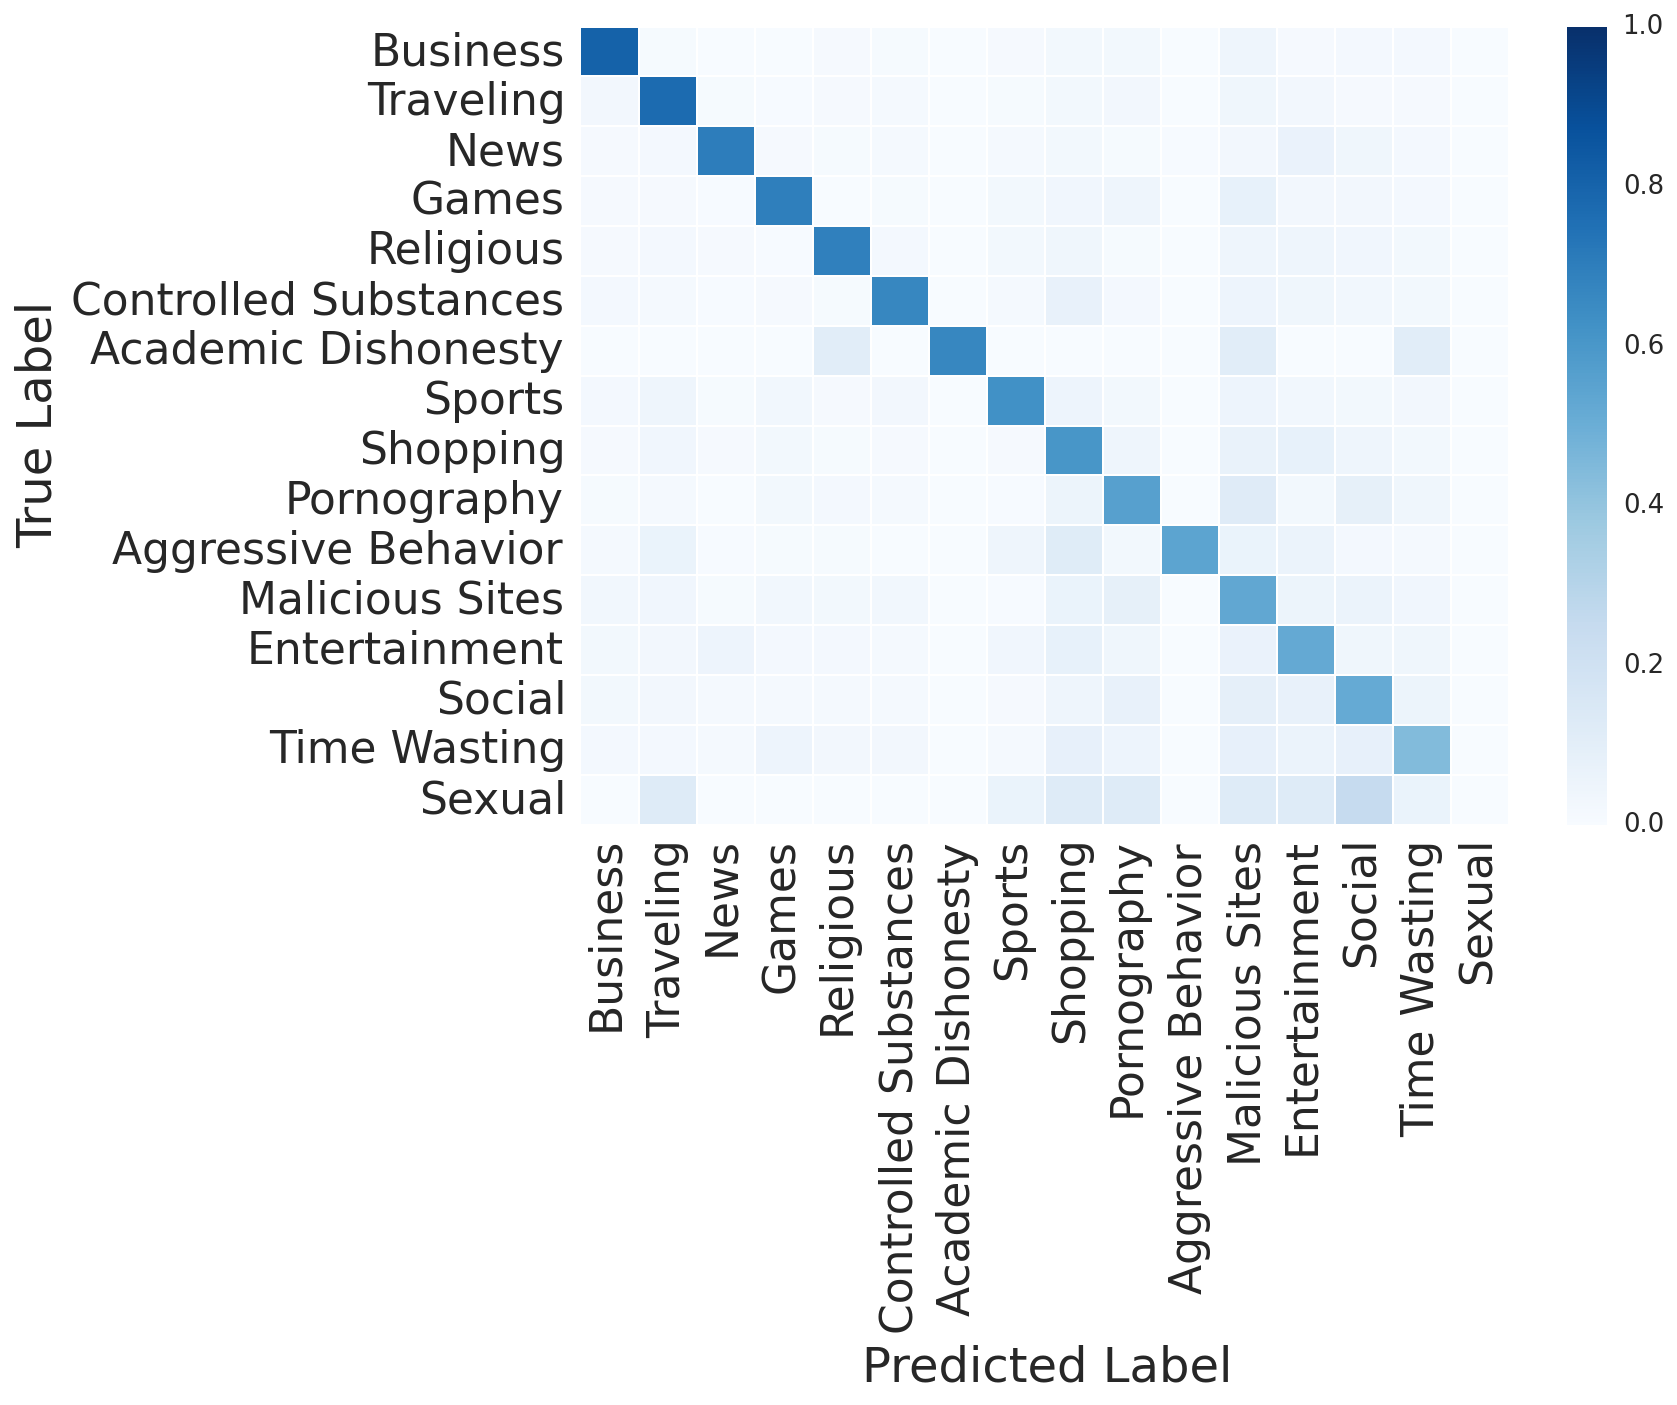

In [20]:
set_style()
plot_confusion_matrix(y_test, pred, normalize=True, cbar=True, cmap='Blues')
plt.savefig(join(save_path, 'NaiveBayesConfusionMatrix-10-2-2015.eps'),tranparent =True)
 

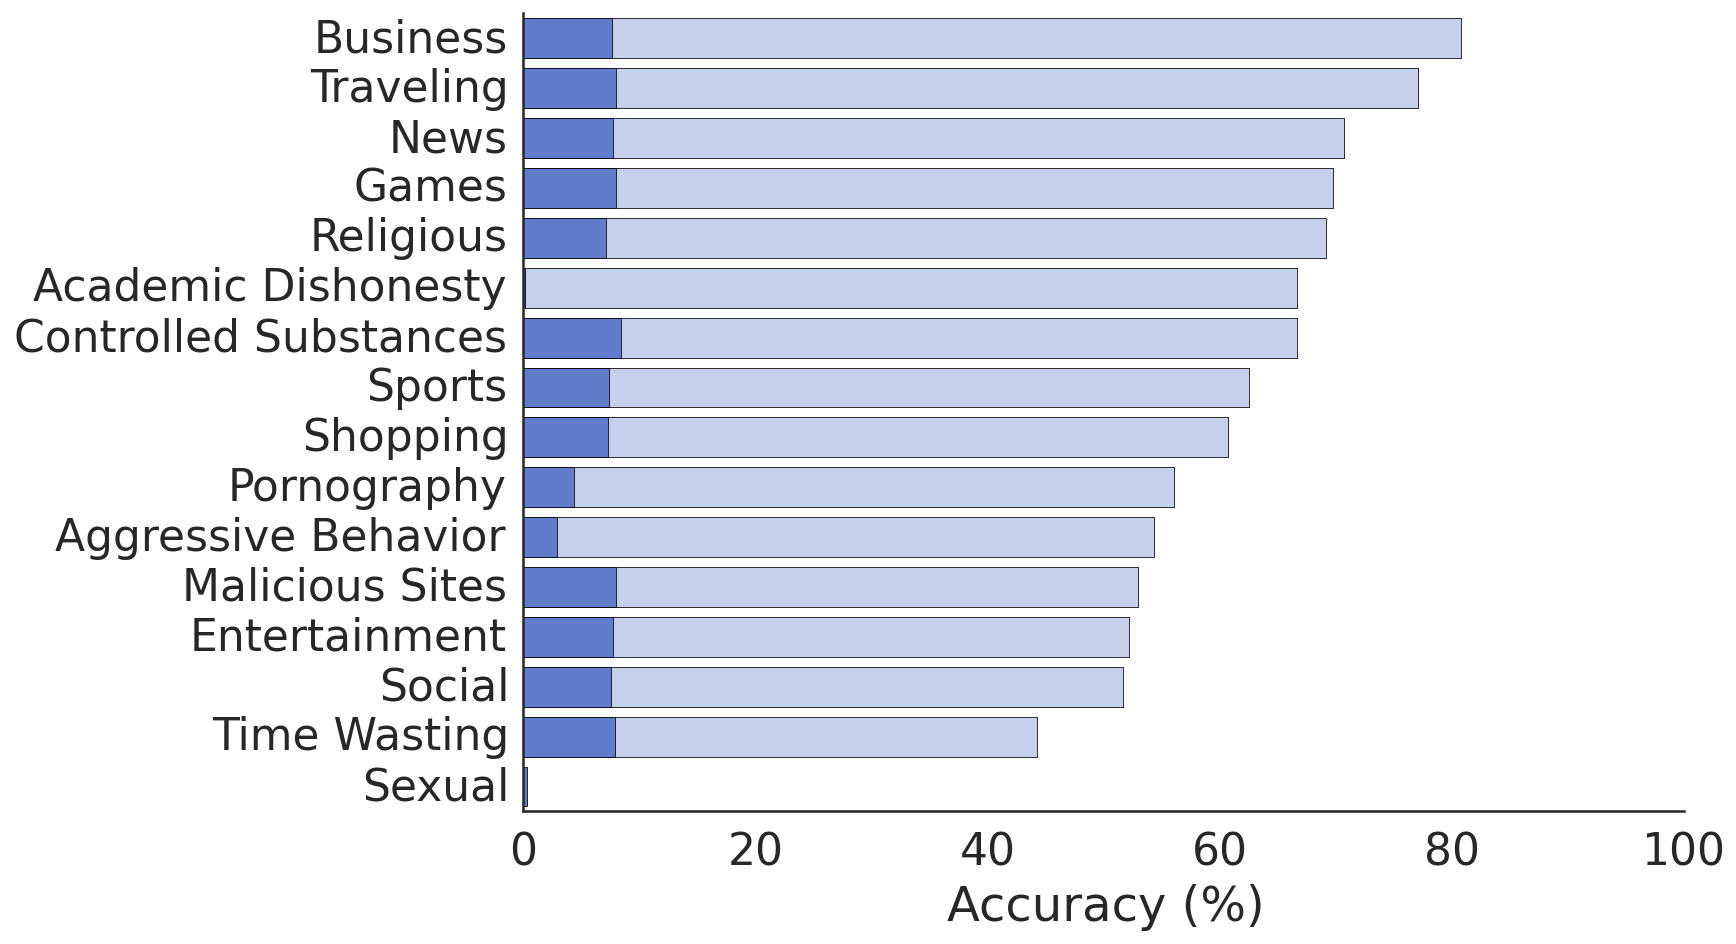

In [21]:
ax, res = plot_accuracy_with_random_by_category(y_test, pred, sort =True)
plt.savefig(join(save_path, 'NaiveBayesAccuracyPlot-10-2-2015.eps'),tranparent =True)


## Save the best model

For the forest we must use a pickle.

In [ ]:
import pickle
model_path= '/home/ubuntu/data/models'
filename = join(model_path, 'RandomForest-10-02-15.pkl')

output = open(filename, 'wb')
pickle.dump(best, output)
output.close()




## Remarks
The random forest is about the same accuracy as the other models. But it is also quite larger in memory and in the actual machine. I will give the company this. But the model is too huge. Likely because it is not a sparse array? 

In [27]:
best

Pipeline(steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
     ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [28]:
best.get_params()

{'chi2': SelectKBest(k=10000, score_func=<function chi2 at 0x7fb79d892398>),
 'chi2__k': 10000,
 'chi2__score_func': <function sklearn.feature_selection.univariate_selection.chi2>,
 'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'clf__bootstrap': True,
 'clf__class_weight': None,
 'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__max_features': 'auto',
 'clf__max_leaf_nodes': None,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__min_weight_fraction_leaf': 0.0,
 'clf__n_estimators': 1000,
 'clf__n_jobs': 1,
 'clf__oob_score': False,
 'clf__random_state': None,
 'clf__verbose': 0,
 'clf__warm_start': False,
 'tfidf': TfidfTransformer(norm=u'l

In [ ]:
### 